In [1]:
!pip install tensorflow faiss

### Prepare the dataset

In [2]:
import numpy as np
from tensorflow import keras

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(x_train.shape)

mnist = x_train.reshape(60000, 28*28)
mnist.shape

(60000, 28, 28)


(60000, 784)

### Test the index

In [3]:
import time
import faiss

faiss.omp_set_num_threads(1)

In [4]:
d = mnist.shape[1]

nbits = 6000

LSH = faiss.IndexLSH(d, nbits)
LSH.add(mnist)

D, I = LSH.search(mnist[40].reshape(1, mnist.shape[1]), 100)
print(I)

flat = faiss.IndexFlatL2(mnist.shape[1])
flat.add(mnist)

D, FLAT_I = flat.search(mnist[40].reshape(1, mnist.shape[1]), k=100) 
print(FLAT_I)

[[   40 19446 47434 34359 17928  3604  3714 34613  3418 50709 15786 44210
  32765 57855 39095 33992 20810  8166 45366  5530 31045 46984 49512  9161
   6665 18852 45220 43770 34426  2762 37518 49964 18741 23492 47440 49440
  56559 11412 36240 21379   838 30337  1910 41852 43286 11178 40516 29666
  54611 12952 49876 23219  9173 56192 26960 44158 32979 55080 34423 23396
  40694 11432 14234 25822 36968 40348 40864 46507 46915 48444 15380 22794
  30209 14126 18389  4766 16932 37948 50326 34483  4140 18258 52362  4772
  27028 31916 33942 26059 30969 11982 19421  2197 40140 46461  1945 42404
  56696  2227 25606 50842]]
[[   40 19446 34359 47434 34613 50709 17928  3604  3714  3418 44210 57855
  45366 32765  5530 49512 18741 33992 18852 15786 45220  6665   838 37518
  43770 46984  9161 49440 34426 25822 36240 20810 40694 31045  2762 23492
  47440 30337 56559  8166 29666 49964 36968 40864 39095 21379  4772 14234
  44158 55080  1910 34423 46507 11178 48444 37014 16932  9173 12436 56192
  49876 15

In [5]:
# Calculate the recall
I = I.flatten()
FLAT_I = FLAT_I.flatten()
sum([1 for i in I if i in FLAT_I])

81

In [6]:
from faiss import write_index
write_index(LSH, 'save/LSH-6000.index')

### Benchmark

In [7]:
import time

bits = [128, 256, 512, 1024, 2048, 4096, 8126]
indexes =[]
build_time=[]

def build_index(data, n_bits):
    index = faiss.IndexLSH(data.shape[1], n_bits)
    index.add(data)
    return index

for n_bits in bits:
    start = time.time()
    index = build_index(mnist, n_bits=n_bits)
    btime = time.time() - start
    build_time.append(btime)
    indexes.append(index)

print(build_time)

[0.22424030303955078, 0.2881886959075928, 0.4089021682739258, 0.7691531181335449, 1.1667346954345703, 4.1549835205078125, 18.87922167778015]


In [9]:
def recall(pred, true):
    return sum([1 for i in pred if i in true]) / true.size

def benchmark_knn_query(data, indexes, size=1000, k=100):
    result = []

    indices = np.random.choice(data.shape[0], size, replace=False)
    for index in indexes:
        query_time = 0
        cur_recall = 0

        # query
        for i in indices:
            start = time.time()
            D, I = index.search(data[i].reshape(1, data.shape[1]), k=k)
            query_time += (time.time() - start)
            D, FLAT_I = flat.search(data[i].reshape(1, data.shape[1]), k=k) 
            cur_recall += recall(I.flatten(), FLAT_I.flatten())
        
        result.append((query_time/1000, cur_recall/1000))

    return result

result = benchmark_knn_query(mnist, indexes) 


print(result)    

[(0.0001959972381591797, 0.3723600000000001), (0.000384181022644043, 0.49315000000000037), (0.0007601253986358643, 0.5845600000000002), (0.001181215524673462, 0.6425999999999997), (0.002163499355316162, 0.6699200000000004), (0.004670454740524292, 0.6890999999999998), (0.008460121154785156, 0.69947)]


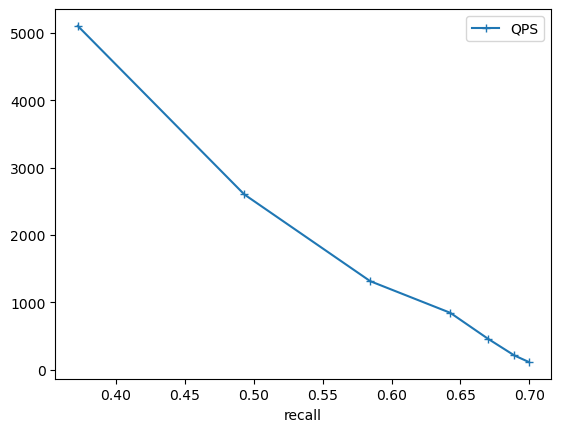

In [10]:
import pandas as pd

df = pd.DataFrame(result, columns=['query_time', 'recall'])
df['QPS'] = 1 / df['query_time']
df.plot(x='recall', y='QPS',style='+-')

import os  
os.makedirs('results', exist_ok=True)
df.to_csv('results/lsh-mnist.csv')

In [ ]:
from faiss import write_index
write_index(indexes[-1], 'save/LSH-8126.index')